# face detection using Tensorflow

In [1]:
import sys
import time
import os
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import cv2
import shutil
from tqdm import tqdm
#import functions as fn

sys.path.append("./")
sys.path.append("./utils/")
sys.path.append("./protos/")

disp_height=1080/1.55
disp_width=1920/1.55

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB =False

if IN_COLAB:
    %matplotlib inline
    from google.colab import drive
    from google.colab.patches import cv2_imshow
    drive.mount('/content/gdrive')
    DRIVE_ROOT='/content/gdrive/My Drive/opencv/'
    !pip install face_recognition
    !pip install webcolors
    if not os.path.exists('./tensorflow-face-detection/'):
      !git clone https://github.com/yeephycho/tensorflow-face-detection
    sys.path.append("./tensorflow-face-detection/")
    sys.path.append("./tensorflow-face-detection/utils/")
    sys.path.append("./tensorflow-face-detection/protos/")
    PATH_TO_CKPT ='./tensorflow-face-detection/model/frozen_inference_graph_face.pb'
    PATH_TO_LABELS = './tensorflow-face-detection/protos/face_label_map.pbtxt'
else:    
    %matplotlib notebook  
    DRIVE_ROOT='./'
    PATH_TO_CKPT = os.path.join(DRIVE_ROOT,'model/frozen_inference_graph_face.pb')
    PATH_TO_LABELS = os.path.join(DRIVE_ROOT,'protos/face_label_map.pbtxt')
    
import label_map_util
import visualization_utils_color as vis_util
import webcolors
DIR_KNOWN_FACE = os.path.join(DRIVE_ROOT,'known_face/')
OUT_DIR = os.path.join(DRIVE_ROOT,'media/')

NUM_CLASSES = 2

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map,max_num_classes=NUM_CLASSES,use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
    (im_width,im_height) = image.size
    return np.array(image.getdata()).reshape((im_height,im_width, 3)).astype(np.uint8)

def name_to_bgr(name):
    (r,g,b)=webcolors.name_to_rgb(name)
    return (b,g,r)


b_bgr=name_to_bgr('blue')
w_bgr=name_to_bgr('white')
r_bgr=name_to_bgr('red')
l_bgr=name_to_bgr('lime')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 100.2MB 34.4MB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566174 sha256=c08e1e8d0529b4dd686c590c352360c1e0b13a48c470a316ab6b317d98666cc5
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models
Cloning into 'tensorflow-face-detection'...
remote: Enumerating

W0804 12:40:28.188243 140612461586304 deprecation_wrapper.py:119] From ./tensorflow-face-detection/utils/label_map_util.py:116: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [3]:
import face_recognition
known_face_names = []
known_face_encodings = []

def scan_known_faces(known_people_folder):
    image_files_in_folder = os.listdir(known_people_folder)
    for name in image_files_in_folder:
        if name.startswith("."):
            continue
        file=os.path.join(known_people_folder,name)
        basename = os.path.splitext(os.path.basename(file))[0]
        img = face_recognition.load_image_file(file)
        encodings = face_recognition.face_encodings(img)

        if len(encodings) > 1:
            print("WARNING: More than one face found in {}. Only considering the first face.".format(file))

        if len(encodings) == 0:
            print("WARNING: No faces found in {}. Ignoring file.".format(file))
        else:
            known_face_names.append(basename)
            known_face_encodings.append(encodings[0])

    return known_face_names, known_face_encodings

scan_known_faces(DIR_KNOWN_FACE)            
print(known_face_names)

['ClassMate1', 'Girl1', 'ClassMate2', 'Suzu', 'Aya', 'Saki', 'Asako', 'Toma', 'boy3', 'boy5', 'boy6', 'girl1', 'girl2', 'girl3', 'boy7', 'boy9', 'boy10', 'girl4', 'boy11', 'boy13', 'boy16', 'boy17', 'boy18']


In [0]:
font = cv2.FONT_HERSHEY_PLAIN
font_scale = 1.2
thickness = 2
def getInterval(fps):
    interval =1.0/fps
    time_wait = (int)(interval * 1000.0)
    #print('interval: ',interval,'time_wait: ',time_wait)
    return interval,time_wait
  
def calc_resize(image,size=None,DEBUG=False):
    if size is None:
        im_height,im_width = image.shape[:2]
    else:
        (im_width,im_height) = size
    if DEBUG:
        print('w',im_width,'h',im_height)
    if im_height>disp_height or im_width>disp_width:
        ratio =min(disp_height/im_height,disp_width/im_width)
        if DEBUG:
            print('r',ratio)
        im_height=int(im_height*ratio)
        im_width=int(im_width*ratio)
    else:
        ratio=1
    if DEBUG:
        print('w',im_width,'h',im_height)
    return (im_width,im_height),ratio

def recognize(image,face_locations,threshold=0.6):
    face_names=[]
    face_scores=[]
    frame = image[:,:,::-1]
    face_encodings = face_recognition.face_encodings(image,face_locations)
    for face_encoding in face_encodings:
        matches = face_recognition.compare_faces(known_face_encodings,face_encoding)
        name = 'unknown'
        
        face_distance = face_recognition.face_distance(known_face_encodings,face_encoding)
        best_match_index = np.argmin(face_distance)
        if matches[best_match_index]:
            if face_distance[best_match_index]<threshold:
                name = known_face_names[best_match_index]
            else:
                name = '?'+known_face_names[best_match_index]
        face_names.append(name)
        face_scores.append(face_distance[best_match_index])
    return face_names,face_scores

def get_detection_graph():
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT,'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph

def boxes_to_face_locations(boxes,scores,image_height,image_width,threshold=0.7):
    # print('threshold',threshold,'boxes',len(boxes))
    face_locations=[]
    for i in range(len(boxes)):
        if scores[i]>threshold:
            #print(i,scores[i])
            ymin,xmin,ymax,xmax = boxes[i]
            top = int(image_height*ymin)
            left=int(image_width*xmin)
            bottom=int(image_height*ymax)
            right=int(image_width*xmax)
            face_locations.append((top,right,bottom,left))
            #(top,right,bottom,left)=face_location;
    #print('face_locations',len(face_locations))
    return face_locations

def resize_showimage(in_image,face_locations,face_names,face_scores,size=None,ratio=None,DEBUG=False,time_stamp=None):
    if ratio is None or size is None:
        size,ratio = calc_resize(in_image)
    if DEBUG:
        print(size,ratio)
    image=cv2.resize(in_image,size)
    if time_stamp is not None:
        t_size = cv2.getTextSize(time_stamp,font,font_scale,thickness)
        t_h=t_size[0][1]
        cv2.putText(image, time_stamp, (0,t_h), font,font_scale, l_bgr, thickness)

    for i in range(len(face_locations)):
        face_location=face_locations[i]
        (top,right,bottom,left)=face_location;
        top = int(top*ratio)
        right=int(right*ratio)
        bottom=int(bottom*ratio)
        left=int(left*ratio)
        name=face_names[i]
        if name == 'Toma':
            col=r_bgr
        else:
            col=b_bgr
        image=cv2.resize(image,size)
        cv2.rectangle(image, (left,top), (right,bottom), col,thickness)
        if name != 'unknown':
          score = int((1-face_scores[i])*100)
          s=name+'[{}]'.format(score)  
          text_size = cv2.getTextSize(s, font, font_scale, thickness)
          text_width = text_size[0][0]
          text_height = text_size[0][1]
        
          cv2.rectangle(image, (left, bottom), (left+text_width+thickness, bottom+text_height+thickness), col, cv2.FILLED)
          cv2.putText(image, s, (left,bottom + text_height), font,font_scale, w_bgr, thickness)
    return image

def get_face_images(in_image,face_locations,face_names,face_scores,filter='Toma'):
    face_images=[]
    im_height,im_width = in_image.shape[:2]
    w_bgr=name_to_bgr('white')
    for i in range(len(face_locations)):
        face_location=face_locations[i]
        face_name=face_names[i]
        if filter is None or face_name == filter:
            (top,right,bottom,left)=face_location;
            width=right-left
            half_w=int(width/2)
            height=bottom-top
            half_h=int(height/2)
        
            top=max(0,top-half_h)
            bottom=min(bottom+half_h,im_height-1)
            left=max(0,left-half_w)
            right=min(right+half_w,im_width-1)
            #print("index{},(l,t,r,b):=({},{},{},{}),size:{},{}".format(i,left,top,right,bottom,right-left,bottom-top))
            img=in_image[top : bottom, left : right]
            #print(face_name)
            text_size = cv2.getTextSize(face_name, font, font_scale, thickness)
            text_width = text_size[0][0]
            text_height = text_size[0][1]
        
            cv2.rectangle(img, (0, height*2-1-text_height-thickness), (text_width+thickness, height*2-1), b_bgr, cv2.FILLED)
            cv2.putText(img, face_name, (0,height*2-1), font,font_scale, w_bgr, thickness)
        
            face_images.append(img)
    return face_images

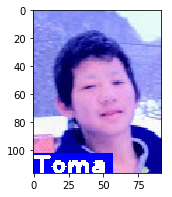

In [7]:
def detect(image,detection_graph,sess):
    image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
    image_np_expanded = np.expand_dims(image_np,axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    start_time = time.time()
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes,scores,classes,num_detections],
        feed_dict={image_tensor: image_np_expanded}
    )
    elapsed_time = time.time() - start_time
    #print('inteference time cost: {}'.format(elapsed_time))
    boxes=np.squeeze(boxes)
    scores=np.squeeze(scores)
    classes=np.squeeze(classes)
    im_height,im_width = image.shape[:2]
            
    face_locations = boxes_to_face_locations(boxes,scores,im_height,im_width)
    #face_names=recognize(image,face_locations)
    #image=resize_showimage(image,face_locations,face_names)
    return face_locations


def detect_face_tf(image):
    detection_graph=get_detection_graph()
    with detection_graph.as_default():
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        with tf.Session(graph=detection_graph, config=config) as sess:
            face_locations = detect(image,detection_graph,sess)
            face_names,face_scores=recognize(image,face_locations,threshold=0.45)
            face_images=get_face_images(image,face_locations,face_names,face_scores)
            image=resize_showimage(image,face_locations,face_names,face_scores)
            return image,face_images

def show_face_image(face_images):        
    n=len(face_images)
    cols=5
    if n<=cols:
        cols=n
        rows=1
    else:
        cols=5
        rows=int(1+n/3)
    fig=plt.figure(figsize=(cols*3,rows*3))
    r=1
    c=1
    i=1
    for image in face_images:
        img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        ax = fig.add_subplot(rows,cols,i)
        ax.imshow(img)
        c+=1
        if c> cols:
            c=0
            r+=1
        i+=1
    plt.show()

def scan_dir(dir_name):
    file_names=os.listdir(dir_name)
    for file_name in file_names:
        image = cv2.imread(os.path.join(dir_name,file_name))
        image,face_images=detect_face_tf(image)
        
def save_face_images(face_images,dir,pre):
    os.makedirs(dir,exist_ok=True)
    for i in range(len(face_images)):
        face_image=face_images[i]
        file_name=os.path.join(dir,'{}_{:2d}.png'.format(pre,i))
        cv2.imwrite(file_name,face_image)
    
#file_name="./test-data/img_report.jpg"
#file_name="./test-data/IMG_5710_s.JPG" # k family
#file_name="./test-data/12.jpg" # N family
file_name=os.path.join(DRIVE_ROOT,"test-data/IMG_4523.JPG") # family
test_dir=os.path.join(DRIVE_ROOT,"test-data")

image=cv2.imread(file_name)
image,face_images=detect_face_tf(image)
show_face_image(face_images)
dir=os.path.join(OUT_DIR,'faces')

save_face_images(face_images,dir,'test')
    # if not IN_COLAB:
    #  cv2.imshow("test",image)
    #  k=cv2.waitKey(0) & 0xFF
    #  if k==27:
    #    break;

    #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #plt.imshow(image)
    #plt.show()

    #cv2.destroyAllWindows()

In [9]:
def recognize_movie(video_file,output_file=None,view=True):
    print(video_file)
    # input
    cap = cv2.VideoCapture(video_file)
    video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # フレーム数を取得する
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count=0
    i_fps=round(fps)
    #print('fps',i_fps)
    #print(video_frame)
    interval,time_wait = getInterval(fps)
    show_size,show_ratio = calc_resize(None,(video_width,video_height))
    counter = 0
    
    # output
    if output_file is not None:
        bd=os.path.splitext(os.path.basename(video_file))[0]
        cap_dir=os.path.join(OUT_DIR,bd)
        face_dir=os.path.join(cap_dir,'faces')
        if os.path.isdir(cap_dir):
            shutil.rmtree(cap_dir)
        os.makedirs(cap_dir,exist_ok=True)
        output_file=os.path.join(OUT_DIR,bd+'.avi')
        if IN_COLAB:
            fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        else:
            fourcc = cv2.VideoWriter_fourcc(*'DIVX')
        writer = cv2.VideoWriter(output_file, fourcc, fps, (video_width, video_height))
    else:
        writer = None

    # ready for tensorflow
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT,'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
        
    with detection_graph.as_default():
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        with tf.Session(graph=detection_graph, config=config) as sess:
            for i in tqdm(range(video_frame)):
#            while cap.isOpened():
                ret,frame = cap.read()
                if not ret:
                    cap.release()
                    break
                frame_count+=1
                
                s,fr=divmod(frame_count,i_fps)
                m,s=divmod(s,60)
                ts='{:02d}:{:02d}.{:d}/{:d}'.format(m,s,fr,i_fps)
                face_locations = detect(frame,detection_graph,sess)
                face_names,face_scores=recognize(frame,face_locations,threshold=0.55)
                if writer is not None:
                    write_image=resize_showimage(frame,face_locations,face_names,face_scores,(video_width,video_height),1.0,time_stamp=ts)
                    writer.write(write_image)
                    if 'Toma' in face_names:
                        index = face_names.index('Toma')
                        counter += 1
                        cap_name='{:02d}m_{:02d}s_{:d}'.format(m,s,fr)+'.png'
                        #print(counter,ts,'[{}]'.format(face_scores[index]))
                        cv2.imwrite(os.path.join(cap_dir,cap_name),write_image)

                        faces=get_face_images(frame,face_locations,face_names,face_scores)
                        save_face_images(faces,face_dir,'{:02d}m_{:02d}s_{:d}'.format(m,s,fr))
                                
                if not IN_COLAB and view:
                    img = resize_showimage(frame,face_locations,face_names,face_scores,show_size,show_ratio,time_stamp=ts)
                    cv2.imshow("detect_by_tensorflow",img)
                    k=cv2.waitKey(time_wait) & 0xFF
                    if k==27:
                        break;
            cv2.destroyAllWindows()
            cap.release()
            return counter
#v_file=os.path.join(DRIVE_ROOT,'gassou_15sec_small.mp4')
#v_file=os.path.join(DRIVE_ROOT,'gassou_15sec_large.mp4')
v_file=os.path.join(DRIVE_ROOT,'gassou_full_large.mp4')
#v_file=os.path.join(DRIVE_ROOT,'gassou_full_small.mp4')
#o_file = './media/out_15_S.avi'

start_time = time.time()
count=recognize_movie(v_file,True,view=True)
elapsed_time = int(time.time() - start_time)
m, s =divmod(elapsed_time,60)
print()
print('elapsed time: {}:{}'.format(m,s))
print('counter',count)

/content/gdrive/My Drive/opencv/gassou_full_large.mp4
10765


100%|██████████| 10765/10765 [16:51<00:00, 10.65it/s]



elapsed time: 16:52
counter 159


In [0]:
# the original source from web
def origin_proc():
    cap = cv2.VideoCapture('./gassou_30sec_large.mp4')
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    interval,time_wait = fn.getInterval(fps)
    out = None
    print('w:',width,'h:',height)

    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT,'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
        
    with detection_graph.as_default():
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        with tf.Session(graph=detection_graph, config=config) as sess:
            frame_num = 1490
            while frame_num:
                frame_num-=1
                ret, image = cap.read()
                if ret == 0:
                    break
                if out is None:
                    #[h,w] = image.shape[:2]
                    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
                    #out = cv2.VideoWriter("./media/test_out.avi", 0,25.0, (w,h))
                    out = cv2.VideoWriter("./media/test_out.avi", fourcc, fps, (width, height))

                image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
                image_np_expanded = np.expand_dims(image_np,axis=0)
                image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            
                boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            
                scores = detection_graph.get_tensor_by_name('detection_scores:0')
                classes = detection_graph.get_tensor_by_name('detection_classes:0')
                num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            
                start_time = time.time()
                (boxes, scores, classes, num_detections) = sess.run(
                    [boxes,scores,classes,num_detections],
                    feed_dict={image_tensor: image_np_expanded}
                )
                elapsed_time = time.time() - start_time
                #print('inteference time cost: {}'.format(elapsed_time))
            
                vis_util.visualize_boxes_and_labels_on_image_array(
                    image,
                    np.squeeze(boxes),
                    np.squeeze(classes).astype(np.int32),
                    np.squeeze(scores),
                    category_index,
                    use_normalized_coordinates=True,
                    line_thickness=2
                )
                out.write(image)
                image=cv2.resize(image,(960,540))
                cv2.imshow("detect_by_tensorflow",image)
                k=cv2.waitKey(time_wait) & 0xFF
                if k==27:
                    break;

            cv2.destroyAllWindows()
            cap.release()
            out.release()

In [0]:
!ls tensorflow-face-detection/utils -l

total 28
-rw-r--r-- 1 root root     0 Jul 21 11:52 __init__.py
-rw-r--r-- 1 root root  4727 Jul 21 11:52 label_map_util.py
-rw-r--r-- 1 root root 17664 Jul 21 11:52 visualization_utils_color.py
